In [2]:
#r "nuget: xunit, 2.8.1"
#r "nuget:ScottPlot, 5.0.35"

using Xunit;
using Microsoft.DotNet.Interactive.Formatting;
using System;
using System.Collections.Concurrent;
using System.Collections.Generic;
using System.Diagnostics;
using System.Linq;
using System.Threading;
using ScottPlot;
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetImageHtml(600, 600)), HtmlFormatter.MimeType);

Installed Packages ScottPlot, 5.0.35 xunit, 2.8.1

Loading extensions from `C:\Users\yekat\.nuget\packages\skiasharp\2.88.8\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [3]:
static double MeasureBlockingCollection(int itemCount)
    {
        var collection = new BlockingCollection<int>();
        var stopwatch = new Stopwatch();
        var startEvent = new ManualResetEvent(false);
        var endEvent = new ManualResetEvent(false);

        var producer = new Thread(() =>
        {
            startEvent.WaitOne();
            for (int i = 0; i < itemCount; i++)
            {
                collection.Add(i);
            }
            collection.CompleteAdding();
        });

        var consumer = new Thread(() =>
        {
            startEvent.WaitOne();
            foreach (var item in collection.GetConsumingEnumerable())
            {
                
            }
            endEvent.Set();
        });

        producer.Start();
        consumer.Start();

        startEvent.Set();
        stopwatch.Start();

        endEvent.WaitOne();
        stopwatch.Stop();

        return stopwatch.Elapsed.TotalMilliseconds;
    }


In [4]:
static double MeasureConcurrentQueue(int itemCount)
    {
        var queue = new ConcurrentQueue<int>();
        var stopwatch = new Stopwatch();
        var startEvent = new ManualResetEvent(false);
        var endEvent = new ManualResetEvent(false);

        var producer = new Thread(() =>
        {
            startEvent.WaitOne();
            for (int i = 0; i < itemCount; i++)
            {
                queue.Enqueue(i);
            }
        });

        var consumer = new Thread(() =>
        {
            startEvent.WaitOne();
            int item;
            for (int i = 0; i < itemCount; i++)
            {
                while (!queue.TryDequeue(out item))
                {
                    Thread.SpinWait(1);
                }
            }
            endEvent.Set();
        });

        producer.Start();
        consumer.Start();

        startEvent.Set();
        stopwatch.Start();

        endEvent.WaitOne();
        stopwatch.Stop();

        return stopwatch.Elapsed.TotalMilliseconds;
    }

In [5]:
static double MeasureNonThreadSafeQueue(int itemCount)
    {
        var queue = new Queue<int>();
        var stopwatch = new Stopwatch();

        stopwatch.Start();
        for (int i = 0; i < itemCount; i++)
        {
            queue.Enqueue(i);
        }
        for (int i = 0; i < itemCount; i++)
        {
            queue.Dequeue();
        }
        stopwatch.Stop();

        return stopwatch.Elapsed.TotalMilliseconds;
    }

In [6]:
        const int itemCount = 1000000;
        const int iterations = 10;

        var blockingCollectionTimes = new List<double>();
        var concurrentQueueTimes = new List<double>();
        var nonThreadSafeQueueTimes = new List<double>();

        for (int i = 0; i < iterations; i++)
        {
            blockingCollectionTimes.Add(MeasureBlockingCollection(itemCount));
            concurrentQueueTimes.Add(MeasureConcurrentQueue(itemCount));
            nonThreadSafeQueueTimes.Add(MeasureNonThreadSafeQueue(itemCount));
        }


In [7]:
var fastCollection = Math.Min(blockingCollectionTimes.Average(), concurrentQueueTimes.Average());
var ProcentSootnoshenie = (100 * fastCollection) / nonThreadSafeQueueTimes.Average();


BlockingCollection average time: 417.53141000000005 ms
ConcurrentQueue average time: 29.134949999999996 ms
Non-thread-safe Queue average time: 24.340549999999997 ms
Столько процентов составляет самая быстрая коллекция от nonThreadSafeQueueTimes: 119.6971720030977%



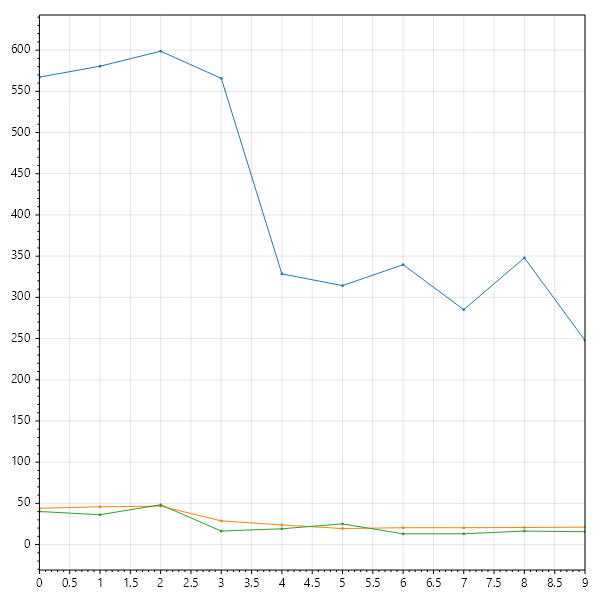

In [8]:
Console.WriteLine("BlockingCollection average time: " + blockingCollectionTimes.Average() + " ms");
        Console.WriteLine("ConcurrentQueue average time: " + concurrentQueueTimes.Average() + " ms");
        Console.WriteLine("Non-thread-safe Queue average time: " + nonThreadSafeQueueTimes.Average() + " ms");
        Console.WriteLine("Столько процентов составляет самая быстрая коллекция от nonThreadSafeQueueTimes" + ": " + ProcentSootnoshenie + "%");
        ScottPlot.Plot plt = new();

        plt.Add.Signal(blockingCollectionTimes);
        plt.Add.Signal(concurrentQueueTimes);
        plt.Add.Signal(nonThreadSafeQueueTimes);
        plt.Axes.SetLimits(0,9);
        plt.SavePng("graph.png", 600, 600);
        plt